# Step 2: Estimate concentration gradient RHL

This notebook estimates RHL concentration gradients by:
This notebook estimates RHL concentration gradients by:
1. Loading binned and corrected fluorescence gradient data from Step 1
2. Converting background-corrected GFP intensities to RHL concentrations using inverse Hybrid Hill-Spline function (from 1_dose_response_curves)
3. Fit analytical solution of diffusion model to concentration gradients to estimate parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import PchipInterpolator
import json
import re
from pathlib import Path
import seaborn as sns

# =========================
# Config
# =========================
# Per-bin (y_bin) RHL data for fitting
RHL_CSV    = Path.cwd() / 'data' / '1_rhl_fluor_gradient_binned.csv'

# Hill calibration JSON (RHL calibration)
JSON        = Path.cwd().parent / '1_dose_response_curves' / 'data' / '2_rhl_calibration_curve.json'

# Outputs
OUTPUT_PROFILE_CSV   = Path.cwd() / 'data' / '2_rhl_concentration_profiles.csv'
OUTPUT_FIT_CSV   = Path.cwd() / 'data' / '2_rhl_diffusion_model_fits.csv'
# User-tunable analysis options
intensity_col   = 'median_intensity'  # column in RHL_CSV to background-correct
cut_off_wall    = 1                   # drop this many leading y_bins (to remove edge effects for fitting) (1)
cut_off_channel = 6                   # drop this many trailing y_bins (to remove edge effects for bg estimation)
L_margin_bins   = 1.0                 # L must be >= last fitted bin + this margin

SPLINE_CLAMP = True


# =========================
# Helpers
# =========================

def std_sinh(z):
    z = np.asarray(z)
    return np.where(np.abs(z) < 1e-8, z, np.sinh(z))

def uptake_diffusion_sinh(x, c_max, L, A):
    """
    Calculates numerically stable uptake–diffusion concentration profile, assuming zero boundary condition at x=L.

    Parameters:
    - x: array-like, positions along the gradient
    - c_max: float, maximum concentration at x=0
    - L: float, length of the domain
    - A: float, uptake/diffusion rate [1/m^2]

    Returns:
    - c: array-like, concentration at positions x
    c(x) = c_max * sinh(sqrt(A)*(L - x)) / sinh(sqrt(A)*L)

    """
    sA = np.sqrt(A)
    return c_max * np.sinh(sA * (L - x)) / np.sinh(sA * L)


def hill_inverse(y, a, c, b):
    """Inverse Hill: c * (y / (a - y))**(1/b)"""
    return c * (y / (a - y))**(1/b)

def intensity_to_concentration(intensity_vec: np.ndarray) -> np.ndarray:
    y_bg = np.asarray(intensity_vec, dtype=float)
    out = np.full_like(y_bg, np.nan, dtype=float)

    if pchip_inverse is None:
        return out

    y_for_spline = y_bg # + CAL_SPLINE_RESPONSE_OFFSET
    y_dom_lo, y_dom_hi = float(pchip_inverse.x[0]), float(pchip_inverse.x[-1])
    mask_finite = np.isfinite(y_for_spline)

    yq = y_for_spline.copy()
    if SPLINE_CLAMP:
        yq[mask_finite & (yq < y_dom_lo)] = y_dom_lo
        yq[mask_finite & (yq > y_dom_hi)] = y_dom_hi

    if spline_cutoff is not None:
        logc_try = np.full_like(yq, np.nan, dtype=float)
        with np.errstate(all='ignore'):
            logc_try[mask_finite] = pchip_inverse(yq[mask_finite])
        c_try = np.power(10.0, logc_try)
        can_use_spline = mask_finite & np.isfinite(c_try) & (c_try <= float(spline_cutoff))
        out[can_use_spline] = c_try[can_use_spline]

        rem_mask = mask_finite & ~can_use_spline
        if rem_mask.any() and None not in (calibration_a, calibration_c, calibration_b):
            y_eff = y_bg[rem_mask] - cal_y0
            valid_hill = np.isfinite(y_eff) & (y_eff >= 0) & (y_eff < calibration_a)
            tmp = np.full_like(y_eff, np.nan, dtype=float)
            tmp[valid_hill] = hill_inverse(y_eff[valid_hill], calibration_a, calibration_c, calibration_b)
            out[rem_mask] = tmp
        return out
    
    with np.errstate(all='ignore'):
        logc = pchip_inverse(yq)
    out[mask_finite] = np.power(10.0, logc[mask_finite])
    return out
    
def process_chamber_background(df_sub, cut_off_wall=0, cut_off_channel=0):
    """
    Process background correction for a chamber group.
    Ensures data is sorted by y_bin before applying cutoffs.

    Parameters:
    -----------
    df_sub : pd.DataFrame
        Subset dataframe for one replicate/position group
    cut_off_wall : int
        Number of bins to exclude from wall side
    cut_off_channel : int
        Number of bins to exclude from channel side

    Returns:
    --------
    pd.DataFrame
        Original dataframe with added 'bg_corrected' column
    """
    
    if not isinstance(cut_off_wall, (int, np.integer)) or cut_off_wall < 0:
        raise ValueError("cut_off_wall must be a non-negative integer")
    if not isinstance(cut_off_channel, (int, np.integer)) or cut_off_channel < 0:
        raise ValueError("cut_off_channel must be a non-negative integer")
    
    # Sort by y_bin to ensure proper ordering
    df_sorted = df_sub.sort_values('y_bin').reset_index(drop=True)

    # Extract data
    xdata_bins = df_sorted['y_bin'].to_numpy(dtype=float)
    ydata_raw = df_sorted['median_intensity'].to_numpy(dtype=float)

    # Find valid finite values
    valid_raw = np.isfinite(ydata_raw)

    # Create internal row mask (excluding wall and channel edges)
    internalrow = np.zeros_like(ydata_raw, dtype=bool)
    internalrow[cut_off_wall:len(internalrow) - cut_off_channel] = True

    # Calculate background as minimum of valid internal values
    valid_internal = valid_raw & internalrow
    BG_VALUE = float(np.nanmin(ydata_raw[valid_internal]))
  
    # Background correction and clip negatives
    df_sorted['corrected_intensity'] = ydata_raw - BG_VALUE
    df_sorted['bg_value'] = BG_VALUE

    return df_sorted

def propagate_tail_nans_after_second(x, arrays):
    x = np.asarray(x)
    order = np.argsort(x)
    nan_count = 0
    cut_x = None
    for k in order:
        if any(not np.isfinite(a[k]) for a in arrays):
            nan_count += 1
            if nan_count >= 2:
                cut_x = x[k]; break
    if cut_x is None:
        return arrays
    tail_mask = x > cut_x
    out = []
    for a in arrays:
        a2 = a.copy()
        a2[tail_mask] = np.nan
        out.append(a2)
    return out

def fit_diffusion_model(df_corr, cut_off_wall=0, cut_off_channel=0, L_margin_bins=1.0):
    """
    Fit uptake-diffusion model to concentration profiles per chamber.
    Parameters:
    -----------
    df_corr : pd.DataFrame
        Dataframe with concentration profiles per chamber
    cut_off_wall : int
        Number of bins to exclude from wall side for fitting                
    cut_off_channel : int
        Number of bins to exclude from channel side for fitting
    L_margin_bins : float
        Margin added to lower bound of L parameter in fitting
    Returns:
    --------
    df_results : pd.DataFrame
        Summary of fit results per chamber
    df_fitted : pd.DataFrame
        'fitted_concentration' column in format of original dataframe
    """
    
    if not isinstance(cut_off_wall, (int, np.integer)) or cut_off_wall < 0:
        raise ValueError("cut_off_wall must be a non-negative integer")
    if not isinstance(cut_off_channel, (int, np.integer)) or cut_off_channel < 0:
        raise ValueError("cut_off_channel must be a non-negative integer")

    # Group by replicate and position
    df_iter = df_corr.groupby(['replicate', 'pos'], group_keys=False)

    results = []
    fitted_data = []

    for (replicate, pos), df_sub in df_iter:

        # Sort by y_bin to ensure proper ordering
        df_sorted = df_sub.sort_values('y_bin')

        # Extract data
        xdata_um = df_sorted['y_um'].to_numpy(dtype=float)
        ydata_conc = df_sorted['concentration'].to_numpy(dtype=float)

        # Create internal row mask (excluding wall and channel edges)
        internalrow = np.zeros_like(ydata_conc, dtype=bool)
        internalrow[cut_off_wall:len(internalrow) - cut_off_channel] = True

        # Trim by cut_off for fitting
        x_fit = xdata_um[internalrow]
        y_fit = ydata_conc[internalrow]

        if x_fit.size < 3:
            c_max_fit = A_fit = L_fit = np.nan
            r2 = rmse = np.nan
            status = 'insufficient_data'
            fit_at_bins = np.full_like(xdata_um, np.nan, dtype=float)

        else:
            # --- Fit with bounds: L beyond data, c_max≥0, A>0 (NO offset) ---
            last_bin_fit = float(np.max(x_fit))
            L_lower = last_bin_fit + max(1.0, float(L_margin_bins))

            def model_free_L(x, c_max, L, A):
                return uptake_diffusion_sinh(x, c_max, L, A)

            yfit_max = float(np.max(y_fit))
            p0 = [max(1e-9, 3.0 * yfit_max), L_lower + 1.0, 1.0]
            lb_eps = 1e-12
            lower_bounds = [0.0, L_lower, lb_eps]
            upper_bounds = [np.inf, 2*L_lower, np.inf]

            try:
                popt, _ = curve_fit(
                    model_free_L, x_fit, y_fit,
                    p0=p0, bounds=(lower_bounds, upper_bounds),
                    maxfev=10000
                )
                c_max_fit, L_fit, A_fit = map(float, popt)
                status = 'success'

                y_pred = model_free_L(x_fit, *popt)
                resid = y_fit - y_pred
                ssr = float(np.sum(resid**2))
                tss = float(np.sum((y_fit - np.mean(y_fit))**2))
                r2 = 1 - ssr / tss if tss > 0 else np.nan
                rmse = float(np.sqrt(ssr / y_fit.size)) if y_fit.size > 0 else np.nan

                fit_at_bins = model_free_L(xdata_um, c_max_fit, L_fit, A_fit)

            except Exception as e:
                c_max_fit = A_fit = L_fit = np.nan
                r2 = rmse = np.nan
                status = f'fit_error: {e}'
                fit_at_bins = np.full_like(xdata_um, np.nan, dtype=float)

        # Store fitted values with original index
        fitted_df = pd.DataFrame({
            'fitted_concentration': fit_at_bins
        }, index=df_sorted.index)
        fitted_data.append(fitted_df)

        # Per-fit summary
        results.append({
            'replicate': replicate,
            'pos': pos,
            'c_max': c_max_fit,
            'L': L_fit,
            'A': A_fit,
            'r2': r2,
            'rmse': rmse,
            'status': status
        })

    # Combine all fitted data and assign back to df_corr
    df_fitted = pd.concat(fitted_data)

    # Create summary dataframe
    df_results = pd.DataFrame(results)

    return (df_results, df_fitted)

def plot_chamber_profile(df_data, y_column, final_width_in, final_height_in, 
                          font_size, xlim=(0, 50), ylim=(150, 650), 
                          ylabel=None):
    """
    Plot chamber intensity profiles with individual lines and median per replicate.

    Parameters:
    -----------
    df_data : pd.DataFrame
        Data with columns: y_um, replicate, pos, and the specified y_column
    y_column : str
        Name of column to plot on y-axis (e.g., 'median_intensity', 'bg_corrected')
    final_width_in : float
        Figure width in inches
    final_height_in : float
        Figure height in inches
    font_size : int
        Base font size for labels
    xlim : tuple, optional
        X-axis limits (default: (0, 50))
    ylim : tuple, optional
        Y-axis limits (default: (150, 650))
    ylabel : str, optional
        Y-axis label

    Returns:
    --------
    ax : matplotlib.axes.Axes
        The axes object
    """
    pos_colors = sns.color_palette("pastel", n_colors=len(df_data['replicate'].unique()))
    med_colors = sns.color_palette("deep", n_colors=len(df_data['replicate'].unique()))

    fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

    # Plot all individual chamber lines
    sns.lineplot(
        data=df_data,
        x='y_um',
        y=y_column,
        hue='replicate',
        palette=pos_colors,
        estimator=None,
        units='pos',
        lw=0.5,
        alpha=0.4,
        legend=False,
        ax=ax
    )

    # Plot median over chambers per replicate
    df_median = df_data.groupby(['replicate', 'y_um'])[y_column].median().reset_index()
    sns.lineplot(
        data=df_median,
        x='y_um',
        y=y_column,
        hue='replicate',
        lw=1.5,
        ax=ax,
        legend=False,
        palette=med_colors
    )

    # Configure axes
    ax.set_xlabel('Distance to PA [µm]', fontsize=font_size)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=font_size)
    ax.tick_params(labelsize=font_size-1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return ax

def plot_fit_summary(df_fit_results, cols_to_plot, fig_size=(6, 3), nrow=1, axlims_dict=None, mode='per_replicate', axlabel_dict=None):
    """
    Plot summary of fit results with stripplot and pointplot.

    Parameters:
    -----------
    df_fit_results : pd.DataFrame
        Dataframe with fit results per chamber
    cols_to_plot : list of str
        List of column names to plot
    fig_size : tuple, optional
        Figure size in inches (default: (6, 3))
    nrow : int, optional
        Number of rows in the subplot grid (default: 1)
    axlims_dict : dict, optional
        Dictionary with axis limits per column, and number of ticks, e.g., {'c_max': (0, 500, 6)}
    mode : str, optional
        Mode of plotting, either 'per_replicate' or 'combined' (default: 'per_replicate')
    axlabel_dict : dict, optional
        Dictionary with x-axis labels per column for 'combined' mode

    Returns:
    --------
    axs : np.ndarray
        Array of axes objects
    """

    if mode not in ['per_replicate', 'combined']:
        raise ValueError("Invalid mode specified, must be 'per_replicate' or 'combined'.")
    
    ncol =  int(np.ceil(len(cols_to_plot) / nrow))

    fig,axs = plt.subplots(nrow,ncol,figsize=fig_size)
    font_size = 8

    def calc_iqr(x):
        q1 = np.percentile(x, 25)
        q3 = np.percentile(x, 75)
        return (q1, q3)

    for ax, col in zip(axs.flatten(), cols_to_plot):

        xcol = 'replicate' if mode == 'per_replicate' else None
        sns.stripplot(
            data=df_fit_results,
            x=xcol,
            y=col,
            hue='replicate',
            size=4,
            palette='pastel',
            alpha=0.75,
            ax=ax,
            zorder=1
        )

        # Build base arguments
        plot_kwargs = {
            'data': df_fit_results,
            'y': col,
            'estimator': 'median',
            'errorbar': calc_iqr,
            'markers': '_',
            'markersize': 20,
            'markeredgewidth': 3,
            'linewidth': 2,
            'ax': ax,
            'zorder': 2
        }
        
        if mode == 'per_replicate':
            plot_kwargs['x'] = 'replicate'
            plot_kwargs['hue'] = 'replicate'
            plot_kwargs['palette'] = 'dark'
        elif mode == 'combined':
            xcol = None
            plot_kwargs['color'] = [0.4,0.4,0.4] 
            plot_kwargs['legend'] = False
            plot_kwargs['alpha'] = 1
            plot_kwargs['markersize'] = 30

        sns.pointplot(**plot_kwargs)
    
        if axlims_dict and col in axlims_dict:
            ax.set_ylim(axlims_dict[col][0:2])
            ax.set_yticks(np.linspace(axlims_dict[col][0], axlims_dict[col][1], axlims_dict[col][2]))

        ax.tick_params(labelsize=font_size-1)
        ax.tick_params(labelsize=font_size-1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, alpha=0.3)

        if mode == 'combined':
            ax.set_ylabel(axlabel_dict.get(col, '') if axlabel_dict else col, fontsize=font_size)

            # calculate median over medians
            med_med = df_fit_results.groupby('replicate').median(numeric_only=True).median()
            med_med = df_fit_results.groupby('replicate').median(numeric_only=True).median().to_frame('value').T
            med_med.index = ['rhl']

            sns.pointplot(
                data=med_med,
                y=col,
                color=[0.2,0.2,0.2],
                markers='D',
                markersize=5,
                markeredgewidth=2,
                ax=ax,
                zorder=3
            )
            ax.legend_.remove()

            # Calculate statistics
            stats = df_fit_results[col].quantile([0.05, 0.25, 0.5, 0.75, 0.95]).to_numpy()
            text_str = f"Median: {stats[2]:.4g}\n25-75%: ({stats[1]:.4g} - {stats[3]:.4g})\n5-95%: ({stats[0]:.4g} - {stats[4]:.4g}\nMedian of Medians: {med_med[col].iloc[0]:.4g}"

            # Place text above the axis
            ax.text(
                0.5, 1.2,  # x=0.5 (center), y=1.02 (above plot area)
                text_str,
                transform=ax.transAxes,
                fontsize=font_size-1,
                verticalalignment='bottom',  # Anchor at bottom so text grows upward
                horizontalalignment='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
            )
        else:
            ax.set_xticklabels([])
            ax.set_ylabel('')
            ax.set_title(col, fontsize=font_size)

    num_panels = nrow * ncol
    if len(cols_to_plot) < num_panels:
        for i in range(len(cols_to_plot), num_panels):
            axs.flatten()[i].set_visible(False)

    plt.tight_layout()

    return axs



In [2]:
# =========================
# Load calibration
# =========================
with open(JSON, "r") as f:
    cal = json.load(f)

calibration_a  = cal.get("params", {}).get("a", None)
calibration_c  = cal.get("params", {}).get("c", None)
calibration_b  = cal.get("params", {}).get("b", None)
cal_y0 = float(cal.get("y0", 0.0))

spline_xlog10 = cal.get("spline_xlog10", None)
spline_y      = cal.get("spline_y", None)
spline_cutoff = cal.get("spline_cutoff", None)
CAL_SPLINE_RESPONSE_OFFSET = float(cal.get("spline_response_offset", cal_y0))

pchip_forward = None
pchip_inverse = None
_xlog_arr_for_selftest = None

if spline_xlog10 is not None and spline_y is not None:
    xlog_arr = np.asarray(spline_xlog10, dtype=float)
    y_arr    = np.asarray(spline_y, dtype=float)
    order = np.argsort(xlog_arr)
    xlog_arr = xlog_arr[order]
    y_arr    = y_arr[order]

    pchip_forward = PchipInterpolator(xlog_arr, y_arr, extrapolate=False)

    y_mono = np.maximum.accumulate(y_arr)
    y_unique, idx = np.unique(y_mono, return_index=True)
    xlog_unique = xlog_arr[idx]
    if len(y_unique) >= 2:
        pchip_inverse = PchipInterpolator(y_unique, xlog_unique, extrapolate=False)
        print(f"[spline] inverse ready; intensity domain: [{pchip_inverse.x[0]:.6g}, {pchip_inverse.x[-1]:.6g}]")
    else:
        print("[spline] not enough unique points to build inverse; spline disabled.")
    _xlog_arr_for_selftest = xlog_arr.copy()


if (pchip_forward is not None) and (pchip_inverse is not None):
    grid = np.linspace(_xlog_arr_for_selftest.min(), _xlog_arr_for_selftest.max(), 250)
    y_sim = pchip_forward(grid)
    logc_back = pchip_inverse(y_sim)
    err = np.nanmax(np.abs(grid - logc_back))
    print(f"[self-test] max |log10c − inverse(forward)| = {err:.3e}")


[spline] inverse ready; intensity domain: [269.533, 7245.61]
[self-test] max |log10c − inverse(forward)| = 4.130e-01


Using y_fit from 1.5 to 45.0 um (cut_off_wall=1, cut_off_channel=6)


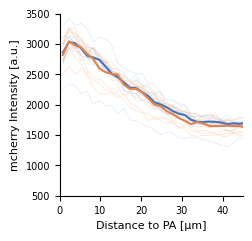

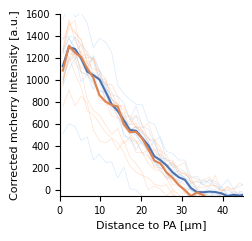

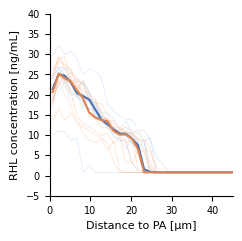

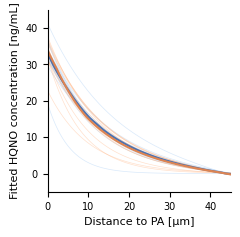

In [3]:
# --- Main analysis ---
# Load main per-bin data & fit (per-chamber min-bin background)
df_corr = pd.read_csv(RHL_CSV)

# report y_fit range
y_vals = df_corr['y_um'].unique();
y_fit = y_vals[cut_off_wall: len(y_vals) - cut_off_channel];
dy = y_fit[1] - y_fit[0]
print(f"Using y_fit from {y_fit[0]-dy/2} to {y_fit[-1]+dy/2} um (cut_off_wall={cut_off_wall}, cut_off_channel={cut_off_channel})")

# Apply background correction per chamber, using min-bin method
# df_corr = (df_fluor_raw
#           .groupby(['replicate', 'pos'], group_keys=False)
#           .apply(process_chamber_background, 
#                  cut_off_wall=cut_off_wall, 
#                  cut_off_channel=cut_off_channel,
#                  include_groups=True))

# Background-corrected fluorescence (clipped at 0)
corrected_fluor_fit = np.clip(df_corr['corrected_intensity'], 0, None)

# Calculate concentration
df_corr['concentration'] = intensity_to_concentration(corrected_fluor_fit)

# Fit uptake-diffusion model to concentration profiles
df_fit_results, df_fitted = fit_diffusion_model(
    df_corr, 
    cut_off_wall=cut_off_wall, 
    cut_off_channel=cut_off_channel, 
    L_margin_bins=L_margin_bins)

df_fit_results['r0'] = 1 / np.sqrt(df_fit_results['A'])
df_corr['fitted_concentration'] = df_fitted['fitted_concentration']

# Export background-corrected intensities
df_corr.to_csv(OUTPUT_PROFILE_CSV, index=False)

# Export fit results
df_fit_results.to_csv(OUTPUT_FIT_CSV, index=False)

final_width_in = 6 / 2.54
final_height_in = 6 / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

ax = plot_chamber_profile(df_corr, 'median_intensity', 
                           final_width_in, final_height_in, font_size, 
                           ylabel= 'mcherry Intensity [a.u.]',ylim=(500, 3500), xlim=(0, 45))
plt.savefig(Path.cwd() / 'figures' / '2_rhl_fluor_gradient_raw.pdf', dpi=300, transparent=True)
plt.show()

ax = plot_chamber_profile(df_corr, 'corrected_intensity', 
                           final_width_in, final_height_in, font_size, 
                           ylabel= 'Corrected mcherry Intensity [a.u.]',
                           ylim=(-50, 1600), xlim=(0, 45))
plt.savefig(Path.cwd() / 'figures' / '2_rhl_fluor_gradient_corrected.pdf', dpi=300, transparent=True)
plt.show()

ax = plot_chamber_profile(df_corr, 'concentration', 
                           final_width_in, final_height_in, font_size, 
                           ylabel= 'RHL concentration [ng/mL]',
                           ylim=(-5, 40), xlim=(0, 45))
plt.savefig(Path.cwd() / 'figures' / '2_rhl_concentration_gradient.pdf', dpi=300, transparent=True)
plt.show()

# Generate high-resolution fitted curves for plotting
y_fit = np.linspace(0, 45, 100)
high_res_fits = []
for _, row in df_fit_results.iterrows():
    c_max = row['c_max']
    L = row['L']
    A = row['A']
    y_fit_curve = uptake_diffusion_sinh(y_fit, c_max, L, A)
    fit_df = pd.DataFrame({
        'replicate': row['replicate'],
        'pos': row['pos'],
        'y_um': y_fit,
        'fitted_concentration': y_fit_curve
    })
    high_res_fits.append(fit_df)

high_res_fits_df = pd.concat(high_res_fits, ignore_index=True)

ax = plot_chamber_profile(high_res_fits_df, 'fitted_concentration', 
                           final_width_in, final_height_in, font_size, 
                           ylabel= 'Fitted HQNO concentration [ng/mL]',
                           ylim=(-5, 45), xlim=(0, 45))
plt.savefig(Path.cwd() / 'figures' / '2_hqno_fitted_concentration_gradient.pdf', dpi=300, transparent=True)
plt.show()

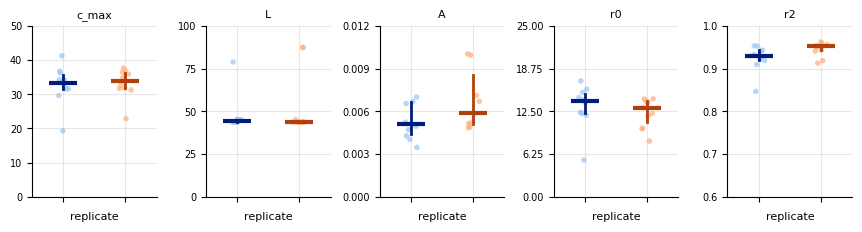

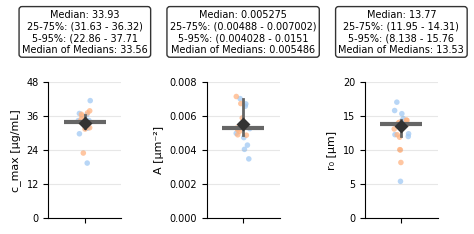

In [12]:
# --- Plot fit results summary ---
axlabel_dict = {
    'c_max': 'c_max [µg/mL]',
    'L': 'L [µm]',
    'A': 'A [µm⁻²]',
    'r0': 'r₀ [µm]',
    'r2': 'R²'
}

axlims_dict = {
    'r2': (0.6, 1, 5),
    'c_max': (0, 50, 6),
    'L': (0, 100,5),
    'A': (0, 0.012,5),
    'r0': (0, 25,5)
}

axs = plot_fit_summary(df_fit_results, ['c_max', 'L', 'A', 'r0', 'r2'], fig_size=(22/2.54, 6/2.54), nrow=1, axlims_dict=axlims_dict, mode='per_replicate')
plt.savefig(Path.cwd() / 'figures' / '2_rhl_diffusion_model_fit_per_rep.pdf', dpi=300, transparent=True)
plt.show()

axlims_dict = {
    'c_max': (0, 48, 5),
    'A': (0, 0.008,5),
    'r0': (0, 20,5)
}

axs = plot_fit_summary(df_fit_results, ['c_max', 'A', 'r0'], fig_size=(12/2.54, 6/2.54), nrow=1, axlims_dict=axlims_dict, mode='combined', axlabel_dict=axlabel_dict)
plt.savefig(Path.cwd() / 'figures' / '2_rhl_diffusion_model_fit.pdf', dpi=300, transparent=True)
plt.tight_layout()
plt.show()

## Quality control figures

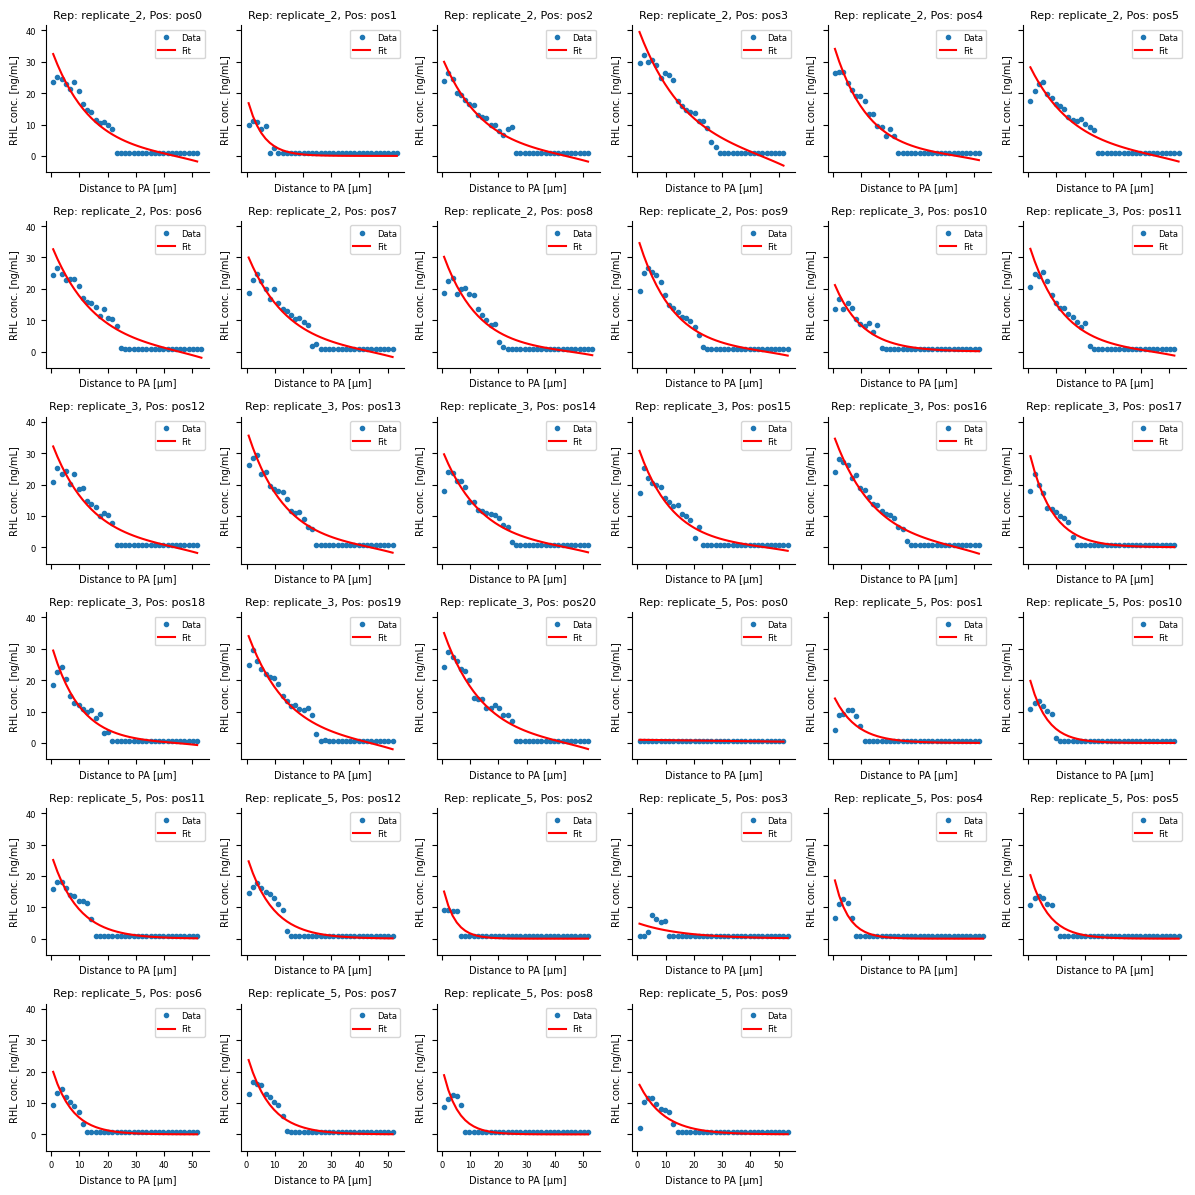

In [5]:
# --- Plot individual chamber concentration profiles with fits ---
n_unique = df_corr.groupby(['replicate', 'pos']).ngroups
n_unique
nrow = 6 
ncol = np.ceil(n_unique / nrow).astype(int)
fig, axs = plt.subplots(nrow, ncol, figsize=(12,12), sharex=True, sharey=True)

for (replicate, pos), df_sub in df_corr.groupby(['replicate', 'pos']):
    ax_idx = list(df_corr.groupby(['replicate', 'pos']).groups.keys()).index((replicate, pos))
    ax = axs.flatten()[ax_idx]

    ax.plot(df_sub['y_um'], df_sub['concentration'], 'o', markersize=3, label='Data')
    ax.plot(df_sub['y_um'], df_sub['fitted_concentration'], '-', color='red', label='Fit')

    ax.set_title(f'Rep: {replicate}, Pos: {pos}', fontsize=8)
    ax.set_xlabel('Distance to PA [µm]', fontsize=7)
    ax.set_ylabel('RHL conc. [ng/mL]', fontsize=7)
    ax.tick_params(labelsize=6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=6)

num_panels = nrow * ncol
if n_unique < num_panels:
    for i in range(n_unique, num_panels):
        axs.flatten()[i].set_visible(False)    

plt.tight_layout()

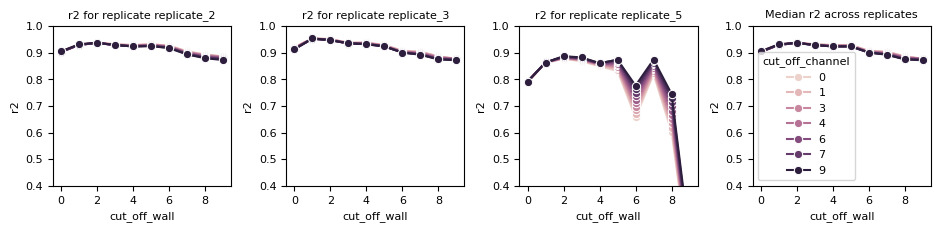

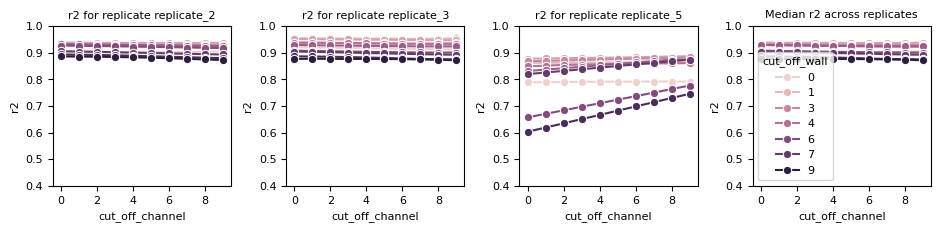

Optimal cut_off_wall: 2.0
Optimal cut_off_channel: 0.0
Maximum R²: 0.938066
Using cut_off_wall: 1, cut_off_channel: 6 for main analysis, results in R² = 0.929415


In [6]:
# --- Analyze cut-off parameter effects on fit R² ---

# Parameter sweep for cutoff optimization
cut_off_wall_list = np.arange(10).astype(int)
cut_off_channel_list = np.arange(10).astype(int)

cols = ['r2']
axlims_dict = {
    'r2': (0.4, 1),
}

result = []
for cut_off_wall_loc in cut_off_wall_list:
    for cut_off_channel_loc in cut_off_channel_list:
        # Background correction per chamber
        df_corr = pd.read_csv(RHL_CSV)

        # Calculate concentration
        df_corr['concentration'] = intensity_to_concentration(df_corr['corrected_intensity'])

        # Fit diffusion model
        df_fit_results, _ = fit_diffusion_model(
            df_corr, cut_off_wall_loc, cut_off_channel_loc, L_margin_bins
        )
        
        df_fit_results[['cut_off_wall', 'cut_off_channel']] = cut_off_wall_loc, cut_off_channel_loc

        result.append(df_fit_results)


# All results combined
df_all = pd.concat(result, ignore_index=True)

# Median per replicate
df_med = (df_all
         .groupby(['cut_off_wall', 'cut_off_channel', 'replicate'])
         .median(numeric_only=True)
         .reset_index())

# Median over replicates        
df_med_med = (df_med
            .groupby(['cut_off_wall', 'cut_off_channel'])
            .median(numeric_only=True)
            .reset_index())

ncols = len(df_med['replicate'].unique()) + 1
nrow = len(cols)
fig, axs = plt.subplots(nrow, ncols, figsize=(24/2.54, 6*nrow/2.54))
axs = np.atleast_1d(axs).flatten() 

for i, col in enumerate(cols):
    # Plot results
    # per replicate
    for j, rep in enumerate(df_med['replicate'].unique()):

        ax = axs[i * ncols + j]
        sns.lineplot(
            data=df_med[df_med['replicate'] == rep],
            x='cut_off_wall', y=col, hue='cut_off_channel',
            marker='o', ax=ax
        )
        ax.set_title(f'{col} for replicate {rep}', fontsize=8)
        ax.set_ylim(axlims_dict[col])
        ax.legend().set_visible(False)

    # median across replicates
    ax = axs[(i + 1) * ncols - 1]
    sns.lineplot(
        data=df_med_med,
        x='cut_off_wall', y=col, hue='cut_off_channel',
        marker='o', ax=ax
    )
    ax.set_title(f'Median {col} across replicates', fontsize=8)
    if i > 0: ax.legend().set_visible(False)
    ax.set_ylim(axlims_dict[col])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrow, ncols, figsize=(24/2.54, 6*nrow/2.54))
axs = np.atleast_1d(axs).flatten() 

for i, col in enumerate(cols):
    # Plot results
    # per replicate
    for j, rep in enumerate(df_med['replicate'].unique()):

        ax = axs[i * ncols + j]
        sns.lineplot(
            data=df_med[df_med['replicate'] == rep],
            hue='cut_off_wall', y=col, x='cut_off_channel',
            marker='o', ax=ax
        )
        ax.set_title(f'{col} for replicate {rep}', fontsize=8)
        ax.set_ylim(axlims_dict[col])
        ax.legend().set_visible(False)

    # median across replicates
    ax = axs[(i + 1) * ncols - 1]
    sns.lineplot(
        data=df_med_med,
        hue='cut_off_wall', y=col, x='cut_off_channel',
        marker='o', ax=ax
    )
    ax.set_title(f'Median {col} across replicates', fontsize=8)
    if i > 0: ax.legend().set_visible(False)
    ax.set_ylim(axlims_dict[col])

plt.tight_layout()
plt.show()

# Find cut_off_wall and cut_off_channel that maximize r2
idx_max_r2 = df_med_med['r2'].idxmax()
optimal_params = df_med_med.loc[idx_max_r2]
print(f"Optimal cut_off_wall: {optimal_params['cut_off_wall']}")
print(f"Optimal cut_off_channel: {optimal_params['cut_off_channel']}")
print(f"Maximum R²: {optimal_params['r2']:.6f}")

r2_selected = df_med_med[
    (df_med_med['cut_off_wall'] == cut_off_wall) & 
    (df_med_med['cut_off_channel'] == cut_off_channel)
]['r2'].values[0]

print(f"Using cut_off_wall: {cut_off_wall}, cut_off_channel: {cut_off_channel} for main analysis, results in R² = {r2_selected:.6f}")
